In [1]:
# In this work we will study the problem of indirect pose estimation, where the objective is to 
# understand how an RGB-D camera move in between two frames, i.e., the transform between the two cameras.
# Once this transformation matrix is obtained, we use both images to create a unified point cloud.

import matplotlib.pyplot as plt
%matplotlib inline

import os
import random

import cv2
import numpy as np

import open3d as o3d
import copy

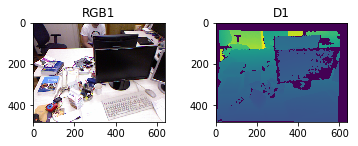

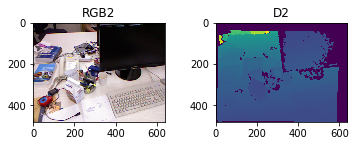

In [2]:
# Load and visualize images

color_raw1 = o3d.io.read_image('rgb1.png')
depth_raw1 = o3d.io.read_image('depth1.png')
rgbd_image1 = o3d.geometry.RGBDImage.create_from_tum_format(color_raw1, depth_raw1, convert_rgb_to_intensity=False)

color_raw2 = o3d.io.read_image('rgb2.png')
depth_raw2 = o3d.io.read_image('depth2.png')
rgbd_image2 = o3d.geometry.RGBDImage.create_from_tum_format(color_raw2, depth_raw2, convert_rgb_to_intensity=False)

rgb1 = np.asarray(rgbd_image1.color)
rgb2 = np.asarray(rgbd_image2.color)

depth1 = np.asarray(rgbd_image1.depth)
depth2 = np.asarray(rgbd_image2.depth)

plt.subplot(2, 2, 1)
plt.title('RGB1')
plt.imshow(rgbd_image1.color)
plt.subplot(2, 2, 2)
plt.title('D1')
plt.imshow(rgbd_image1.depth)
plt.show()
plt.subplot(2, 2, 3)
plt.title('RGB2')
plt.imshow(rgbd_image2.color)
plt.subplot(2, 2, 4)
plt.title('D2')
plt.imshow(rgbd_image2.depth)
plt.show()

In [3]:
# Camera intrinsics, focal length and focal points

width = 640
height = 480
fx = 517.306408
fy = 516.469215
cx = 318.643040
cy = 255.313989

# Coefficients for undistortion 

k1 = 0.262383
k2 = -0.953104
p1 = -0.005358
p2 = 0.002628
k3 = 1.163314

# Point cloud visualizer from open3d, please note o3d.visualization.draw_geometries() will open a window.
# Check the results and CLOSE the pop-up window to proceed to the next cell.

pinholeCameraIntrinsic = o3d.camera.PinholeCameraIntrinsic(
            o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

pinholeCameraIntrinsic.set_intrinsics(width=width, height=height, fx=fx, fy=fy, cx=cx, cy=cy)

print(pinholeCameraIntrinsic)
print(pinholeCameraIntrinsic.intrinsic_matrix)

pcd1 = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image1,
        pinholeCameraIntrinsic)

pcd2 = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image2,
        pinholeCameraIntrinsic)

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])
    #o3d.visualization.draw_geometries([source_temp])

draw_registration_result(pcd2, pcd1, np.identity(4))

camera::PinholeCameraIntrinsic with width = 640 and height = 480.
Access intrinsics with intrinsic_matrix.
[[517.306408   0.       318.64304 ]
 [  0.       516.469215 255.313989]
 [  0.         0.         1.      ]]


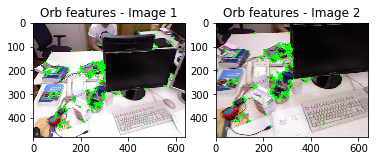

In [4]:
# Extract orb features and draw them on the images

orb = cv2.ORB_create(nfeatures=1200)

kp1, des1 = orb.detectAndCompute(rgb1, None)
kp2, des2 = orb.detectAndCompute(rgb2, None)

rgb11 = cv2.drawKeypoints(rgb1, kp1, None, color=(0,255,0), flags=0)
rgb22 = cv2.drawKeypoints(rgb2, kp2, None, color=(0,255,0), flags=0)


fig1 = plt.gcf()

plt.subplot(1, 2, 1)
plt.title('Orb features - Image 1')
plt.imshow(rgb11)
plt.subplot(1, 2, 2)
plt.title('Orb features - Image 2')
plt.imshow(rgb22)
plt.show()

fig1.savefig('orb_features_detected.png',dpi=400)

# To obtain the pixel level correspondence between the two images we make use of ORB descriptors.
# The obtained descriptors in each image frame are shown below:


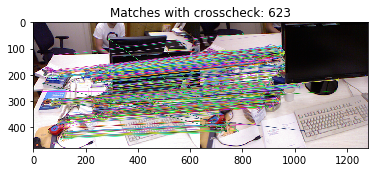

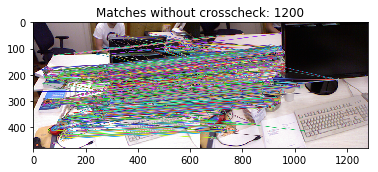

In [5]:
# Brute force matching, crossCheck flag is for reciprocal check. 
# Set it to false will results in more wrong matches.

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)
# Why is it important to sort the matches?


bf_no_cross_check = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
matches_no_cross_check = bf_no_cross_check.match(des1, des2)

# We get the double of matches if we do not cross-check
# From the documentation: If crossCheck==true only return pairs (i,j) 
# such that for i-th query descriptor the j-th descriptor in the matcher's 
# collection is the nearest and vice versa, i.e. the BFMatcher will only 
# return consistent pairs. Such technique usually produces best results 
# with minimal number of outliers when there are enough matches.

img12 = cv2.drawMatches(rgb1, kp1, rgb2, kp2, matches, None, flags=2)


fig2 = plt.gcf()

plt.title('Matches with crosscheck: ' + str(len(matches)))
plt.imshow(img12)
plt.show()

fig2.savefig('matches_between_figures_cross_check.png',dpi=400)

fig2 = plt.gcf()
#plt.subplot(2, 1, 2)
img12_no_cross_check = cv2.drawMatches(rgb1, kp1, rgb2, kp2, matches_no_cross_check, None, flags=2)
plt.title('Matches without crosscheck: ' + str(len(matches_no_cross_check)))
plt.imshow(img12_no_cross_check)
plt.show()

fig2.savefig('matches_between_figures_no_cross_check.png',dpi=400)

# The descriptors in itself are of little value, unless they can be matched within the two images. 
# We therefore perform a matching to find out how do the descriptors relate to each other in both images. 
# The match can be performed with cross-check or without. Using cross-check will usually yield better matches,
# however they will be fewer. In these two frames we have a good amount of cross-check matches, and therefore
# we will only use those to ensure that we are using the matches of high quality.


In [6]:
# Reformatting the keypoints of image 1 (kp1) and image 2 (kp2) from CVKeypoint to numpy array.
uv1 = np.array([k.pt for k in kp1]).astype(np.float32)
uv2 = np.array([k.pt for k in kp2]).astype(np.float32)

# Discard points have no depths from RGB-D camera.
ind1 = []
ind2 = []
for cnt in range(len(matches)):
      
    dep2 = depth2[np.rint(uv2[matches[cnt].trainIdx, 1]).astype(int), np.rint(uv2[matches[cnt].trainIdx, 0]).astype(int)]
    if dep2 < 1e-3:
        continue
    
    # For image 1 we will keep its U and V image coordinates
    ind1.append(uv1[matches[cnt].queryIdx])
    # For image 2 we will keep its U and V image coordinates, as well as the depth in the world
    ind2.append([uv2[matches[cnt].trainIdx, 0], uv2[matches[cnt].trainIdx, 1], dep2])

ind1 = np.array(ind1, np.float32)
ind2 = np.array(ind2, np.float32)
ind2_raw = ind2.copy()

# List points into 3D with projection function.
ind2[:,0] = (ind2[:,0] - cx) * ind2[:,2] / fx
ind2[:,1] = (ind2[:,1] - cy) * ind2[:,2] / fy
 
K = np.eye(3)
K[0,0] = fx 
K[1,1] = fy
K[0,2] = cx
K[1,2] = cy

distCoeffs = np.array([k1,k2,p1,p2,k3])
print(K)
print(distCoeffs)

[[517.306408   0.       318.64304 ]
 [  0.       516.469215 255.313989]
 [  0.         0.         1.      ]]
[ 0.262383 -0.953104 -0.005358  0.002628  1.163314]


In [7]:
# RANSAC for PnP, students are required to finish two parts: (1) eval_pnp() function and (2) the actual RANSAC loop.
# PnP Perspective-n-Point[1] is the problem of estimating the pose of a calibrated camera given a set of n 3D points 
# in the world and their corresponding 2D projections in the image. The camera pose consists of 6 degrees-of-freedom (DOF)
# which are made up of the rotation (roll, pitch, and yaw) and 3D translation of the camera with respect to the world.

def eval_pnp(ind1, ind2, inliers, cameraMatrix, distCoeffs, doProjection=False):
    
    # arg1 - object points in the object coordinate space, 
    # arg2 - corresponding image points
    retval, rvec, tvec = cv2.solvePnP(ind2[inliers], ind1[inliers], cameraMatrix=K, distCoeffs=distCoeffs)
    # What is retval just a sucess/failure output flag? Documentation does not explain
    # rvec – Output rotation vector (see Rodrigues() ) that, together with tvec, brings points from the model coordinate 
    # system to the camera coordinate system.
    # tvec – Output translation vector
    # Rvec and Tvec are the transform that brings points from the model coordinate system to the camera coordinate system.
    
        
    # Now we can transform from ind2 images to ind1 indexes. So now we can just compute the transform of all points
    # ind2 into ind1_resulting, and then measure the difference between ind1_projected and ind1
    
#     (1) Required part for student, some hints: check projectPoints function from opencv for warping keypoints
#         between frames. Think about how to get the residual as a metric to the quality of the aligment.

    R = cv2.Rodrigues(rvec)[0]
    
    T = np.identity(4)
    T[:3,:3] = R # Top left corner is rotation matrix
    T[:3,3] = tvec.flatten() # Return a copy of the array collapsed into one dimension.
    
    if doProjection:
        ind2_projected_on_image_1, _ = cv2.projectPoints(ind2, rvec, tvec, K, distCoeffs)
        ind2_projected_on_image_1 = ind2_projected_on_image_1.squeeze()
        
        u_vals_1 = ind1[:,0]
        u_vals_2 = ind2_projected_on_image_1[:,0]
        v_vals_1 = ind1[:,1]
        v_vals_2 = ind2_projected_on_image_1[:,1]
        
        u_error = np.absolute(u_vals_1 - u_vals_2)
        u_error = np.sum(u_error)/float(u_error.size)
        
        v_error = np.absolute(v_vals_1 - v_vals_2)
        v_error = np.sum(v_error)/float(v_error.size)
                             
        residual = u_error + v_error
        
        # At each iteration RANSAC will select a handful of randomly chosen matches and compute a transform out of it. 
        # Using that transform it will compute the projection of all points and measure a residual to understand how good the fit is.
        # The residual we chose in this work is simply sum of Euclidean image coordinate distances between 
        # the projected points and their expected position (based on the descriptor matches).
        
        return T, residual, ind2_projected_on_image_1

    return T, residual
 
# set up total iteration times for ransac, set ransac_iter_num to 1 to check how it looks withou RANSAC.

index_all = range(ind1.shape[0])
ransac_iter_num = 1000

residual_best = None
T_best = None
inliers_best = None
ind2_projected_on_image_1_best = None

T_all, _, ind2_projected_on_image_1_all = eval_pnp(ind1, ind2, index_all, cameraMatrix=K, distCoeffs=distCoeffs, doProjection=True)

for iter_ind in range(ransac_iter_num):
    
    inliers_candidate = random.sample(index_all, 10)    
    T, residual, ind2_projected_on_image_1 = eval_pnp(ind1, ind2, inliers_candidate, cameraMatrix=K, distCoeffs=distCoeffs, doProjection=True)
    
    if residual_best is None:
        residual_best = residual
        T_best = T
        inliers_best = inliers_candidate
        ind2_projected_on_image_1_best = ind2_projected_on_image_1
        print('residual_best = ' + str(residual_best))
        
    if residual < residual_best:
        residual_best = residual
        T_best = T
        inliers_best = inliers_candidate
        ind2_projected_on_image_1_best = ind2_projected_on_image_1
        print('residual_best = ' + str(residual_best))
    

# At each iteration RANSAC will select a handful of randomly chosen matches and compute a transform out of it. 
# Using that transform it will compute the projection of all points and measure a residual to understand how good the fit is.
# The residual we chose in this work is simply sum of Euclidean image coordinate distances between 
# the projected points and their expected position (based on the descriptor matches).

# The third figure shows that the projected points seem to align quite well with the matched points on the original image. 
# This can also be seen in the registration result of the point clouds. We first show the bad transform, 
# where we can notice that the same keyboard appears in two distinct place, indicating that the transform is wrong.
# When using RANSAC the results improve significantly, now the keyboards are somewhat aligned. 
# However the result could still be further improved (as will be done in the next section)


residual_best = 14.157834336762235
residual_best = 13.82532792631358
residual_best = 13.814823787637955
residual_best = 13.809840694727686


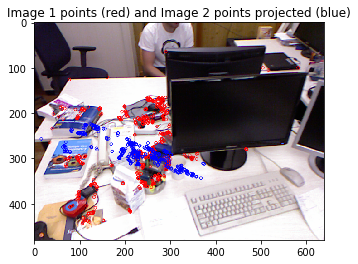

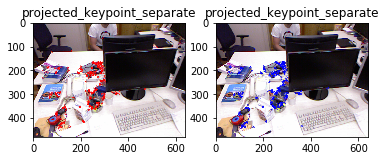

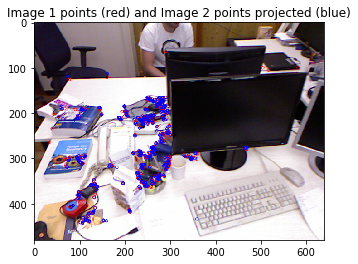

In [8]:
# Visualize the best model by drawing warped points into the same frame.

def corners_to_keypoints(corners):
    if corners is None:
        keypoints = []
    else:
        keypoints = [cv2.KeyPoint(kp[0], kp[1], 1) for kp in corners]
    return keypoints

image_with_keypoints_all = cv2.drawKeypoints(rgb1, corners_to_keypoints(ind1[index_all]), None, color=(255,0,0), flags=0)
image_with_keypoints_all = cv2.drawKeypoints(image_with_keypoints_all, corners_to_keypoints(ind2_projected_on_image_1_all), None, color=(0,0,255), flags=0)

rgb111_separate = cv2.drawKeypoints(rgb1, corners_to_keypoints(ind1[index_all]), None, color=(255,0,0), flags=0)
rgb222_separate = cv2.drawKeypoints(rgb1, corners_to_keypoints(ind2_projected_on_image_1_best), None, color=(0,0,255), flags=0)

rgb111_combined = cv2.drawKeypoints(rgb1, corners_to_keypoints(ind1[index_all]), None, color=(255,0,0), flags=0)
rgb111_combined = cv2.drawKeypoints(rgb111_combined, corners_to_keypoints(ind2_projected_on_image_1_best), None, color=(0,0,255), flags=0)




fig1 = plt.gcf()
plt.title('Image 1 points (red) and Image 2 points projected (blue)')
plt.imshow(image_with_keypoints_all)
plt.show()

fig1.savefig('computed_transform_all_matches.png',dpi=400)




# Check the results and CLOSE the pop-up window to proceed to the next cell.
draw_registration_result(pcd2, pcd1, T_best)
#draw_registration_result(pcd2, pcd1, T_all)

fig2 = plt.gcf()
plt.subplot(1, 2, 1)
plt.title('projected_keypoint_separate')
plt.imshow(rgb111_separate)
plt.subplot(1, 2, 2)
plt.title('projected_keypoint_separate')
plt.imshow(rgb222_separate)
plt.show()

fig3 = plt.gcf()
plt.title('Image 1 points (red) and Image 2 points projected (blue)')
plt.imshow(rgb111_combined)
plt.show()

fig3.savefig('computed_transform_all_matches_ransac.png',dpi=400)


# EXPERIMENT AND COMMENT ON THE BEHAVIOUR WITH THESE SETTINGS: VISUALIZATION OF ALIGNMENTS WITH AND WITHOUT RANSAC
# Now the objective is to understand how points in the 3D space of image 2 project into image 1. 
# To do so we can use function solvePnP(). We start by feeding solvePnP() with the 3D space points 
# of image 2 and the corresponding 2D image points of image 1.
# The correspondence between 3D space points of image 2 and 2D image points of image 1 is done by
# the descriptor matches previously found. The result is seen below:

# The first figure shows that something is wrong. The matching is not properly done. This happens because
# some of the matches between the ORB descriptors are outlies, and they were used to compute the 
# transformation between cameras. To deal with the problem of outliers we use the RANSAC algorithm. 
# At each iteration RANSAC will select a handful of randomly chosen matches and compute a transform out of it. 
# Using that transform it will compute the projection of all points and measure a residual to understand how good the fit is.
# The residual we chose in this work is simply sum of Euclidean image coordinate distances between 
# the projected points and their expected position (based on the descriptor matches).

# The third figure shows that the projected points seem to align quite well with the matched points on the original image. 
# This can also be seen in the registration result of the point clouds. We first show the bad transform, 
# where we can notice that the same keyboard appears in two distinct place, indicating that the transform is wrong.
# When using RANSAC the results improve significantly, now the keyboards are somewhat aligned. 
# However the result could still be further improved (as will be done in the next section)


In [9]:
# Extra part: use the estimated pose from PnP with RANSAC using keypoint, refine it with dense ICP.
# Try to notice the improvement via the visualization, the changes should be noticable.

threshold = 0.02
trans_prior = T_best

print("Apply point-to-point ICP using keypoint estimated pose.")
reg_p2p = o3d.registration.registration_icp(
        pcd2, pcd1, threshold, trans_prior,
        o3d.registration.TransformationEstimationPointToPoint())
# print(reg_p2p)

print("Prior transformation is:")
print(trans_prior)
print("Refined transformation is:")
print(reg_p2p.transformation)
draw_registration_result(pcd2, pcd1, reg_p2p.transformation)

# Comments
# The last step of this assignment consists in using dense ICP (Iterative Closest Point). ICP in itself is not 
# capable of determining the transform between two point clouds, however it is cabable of refining an already 
# existing guess of a transform between two point clouds. The ICP algorithm works by trying to tightly align 
# two point clouds. Running this algorithm we obtained the following result:

# We note now that the keyboard is perfectly aligned. Thus we have managed to arrive at a very precise and 
# accurate transformation between the two camera frames. We note however that the ICP takes a considerable 
# amount of time to run. The RANSAC algorithm however is quite fast, and seems to arrive at a reasonable 
# transform between the two cameras.
# Depending on the application one might use one algorithm or another, or combinations of both. 


Apply point-to-point ICP using keypoint estimated pose.
Prior transformation is:
[[ 0.99966259  0.00529435 -0.02542992 -0.01996224]
 [-0.00314147  0.99646377  0.08396483  0.04177394]
 [ 0.02578453 -0.08385661  0.99614418  0.25817329]
 [ 0.          0.          0.          1.        ]]
Refined transformation is:
[[ 9.99578360e-01  1.49243378e-03 -2.89978455e-02 -2.07029788e-02]
 [ 9.98248982e-04  9.96321506e-01  8.56881574e-02  3.51091526e-02]
 [ 2.90190610e-02 -8.56809749e-02  9.95899927e-01  2.17306318e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
